In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pkg_resources
import glob
from gensim.models.doc2vec import Doc2Vec
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from partyembed.explore import Explore

In [2]:
# load model
m3 = Explore(model = '38_42Parl')

## Figure 2.1
MP embeddings projected onto two dimensions using PCA. Each MP is labelled by party and Parliamentary session.

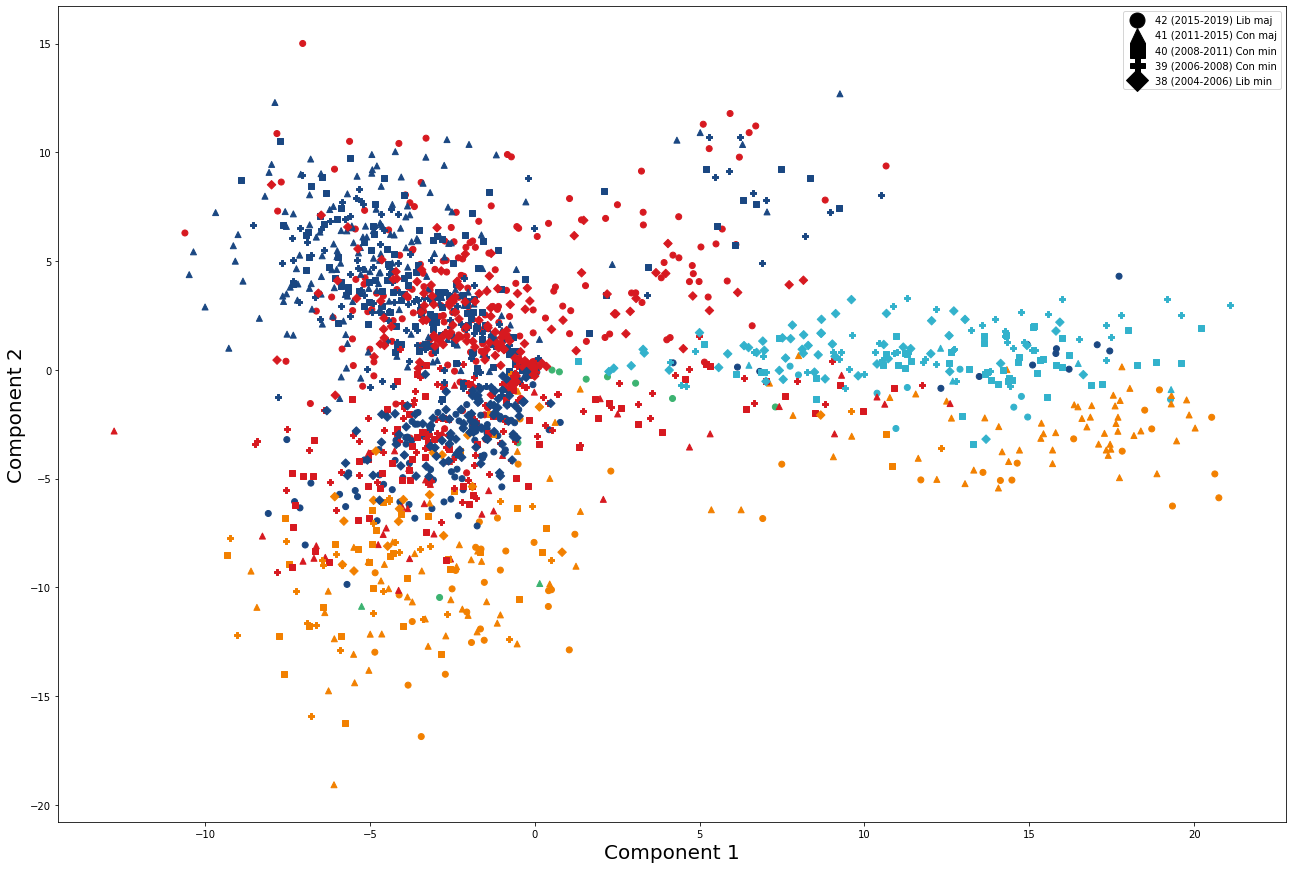

In [3]:
m3.plot()

## Table 2.1
Words and phrases associated with the poles of each axis determined from two-dimensional PCA projection of the MP embeddings.

In [4]:
m3.interpret()

--------------------------------------------------------------------------------
Words Associated with Positive Values (Right) on First Component:
--------------------------------------------------------------------------------
provinc ontario, surrey, piec legisl, coupl, excit, util, brought forward, marketplac, folk, hall, coast coast coast, aggress, substant, fort mcmurray, referenc, move forward, crimin justic, provinc manitoba, sault ste mari, empow
--------------------------------------------------------------------------------
Words Associated with Negative Values (Left) on First Component:
--------------------------------------------------------------------------------
bloc quebecoi, sherbrook, quebec, saguenaylac saint, quebeck, quebec citi, saint jean, des, laval, jean, drummond, joliett, mirabel, gatineau, rosemontla petit, troi rivier, oil compani, dairi produc, fiscal imbal, saint
--------------------------------------------------------------------------------
Words Associ

# Analysis across Parliamentary sessions

In [5]:
# load riding-level data
allParliaments = pd.read_csv('allParliaments_joined.csv')
byParliament = [pd.DataFrame(allParliaments[allParliaments['parliamentNo'] == n]) for n in range (38,43,1)]

In [6]:
from plot_helpers import plot_over_parliament, plot_over_parl_party

In [7]:
# create dataframes for all of the parties seaparately
partynames = ['New Democratic Party', 'Green Party', 'Bloc Québécois', 'Liberal', 'Conservative']
byParliamentAndParty = [[parl[parl['speakerparty'] == party] for party in partynames] for parl in byParliament]


# make axes lists for ease of plotting
partyaxesList = [[[rowi, columni] for rowi in range(0,6,1)] for columni in range(0,6,1)]
parlaxes = [[0,0], [0,1], [1,0], [1,1], [2,0]]

# color dictionary and map
partyColorDict = {'Bloc Québécois':'#33b2cc', 'Conservative':'#1a4782', 'Green Party':'#3d9b35', 'Independent':'#dcdcdc', 'Liberal':'#d71920', 'New Democratic Party':'#f37021', 'Forces et Démocratie':'#dcdcdc'}
provinceColorDict = {'Alberta':'#96C3EB',
                     'British Columbia/Colombie-Britannique':'#FF8D85',
                     'Manitoba':'#FF9933',
                     'New Brunswick/Nouveau-Brunswick':'#CCAC93',
                     'Newfoundland and Labrador/Terre-Neuve-et-Labrador':'#EB96EB',
                     'Northwest Territories/Territoires du Nord-Ouest':'#B8B8B8',
                     'Nova Scotia/Nouvelle-Écosse':'#AFB83B',
                     'Nunavut':'#FAD000',
                     'Ontario':'#FF0000',
                     'Prince Edward Island/Île-du-Prince-Édouard':'#6ACCBC',
                     'Quebec/Québec':'#003399',
                     'Saskatchewan':'#299438',
                     'Yukon':'#884DFF'}

## Table 2.2 
Contingency table for the Quebec versus not-Quebec binary classifier using component 1 values as labels.

In [8]:
doesNotMatchProvince = pd.DataFrame()
quebeckers = pd.DataFrame()
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for i, parliament in enumerate(byParliament):
    for j in parliament.index:
        if (parliament.province[j] == 'Quebec/Québec') and (parliament.quebecker[j]<0):
            doesNotMatchProvince = doesNotMatchProvince.append(parliament.loc[j,:])
            falseNeg += 1
            quebeckers = quebeckers.append(parliament.loc[j,:])
        elif (parliament.province[j] != 'Quebec/Québec') and (parliament.quebecker[j]>0):
            doesNotMatchProvince = doesNotMatchProvince.append(parliament.loc[j,:])
            falsePos += 1
        elif (parliament.province[j] != 'Quebec/Québec') and (parliament.quebecker[j]<0):
            trueNeg += 1
        elif (parliament.province[j] == 'Quebec/Québec') and (parliament.quebecker[j]>0):
            truePos += 1
            quebeckers = quebeckers.append(parliament.loc[j,:])
        else:
            print('error')

# determine the total number of MPs who are "missclassified"
totalMPs = 0
for i in byParliament:
    totalMPs += len(i)


print(f'proportion incorrectly classified (i.e., from QC and pc1<0 or not from QC and pc1>0) is {len(doesNotMatchProvince)} in {totalMPs}, or {len(doesNotMatchProvince)/totalMPs}, yielding accuracy of {(truePos+trueNeg)/totalMPs}')
print(f'true negative = {trueNeg}\nfalse negative = {falseNeg}\nfalse positive = {falsePos}\ntrue positive = {truePos}\ntotal = {totalMPs}')

proportion incorrectly classified (i.e., from QC and pc1<0 or not from QC and pc1>0) is 72 in 1603, or 0.044915782907049284, yielding accuracy of 0.9550842170929508
true negative = 1144
false negative = 8
false positive = 64
true positive = 387
total = 1603


## Figure 2.2
MP embeddings projected onto two dimensions using PCA over the 38th through 42nd Parliaments labelled by provincial origin.

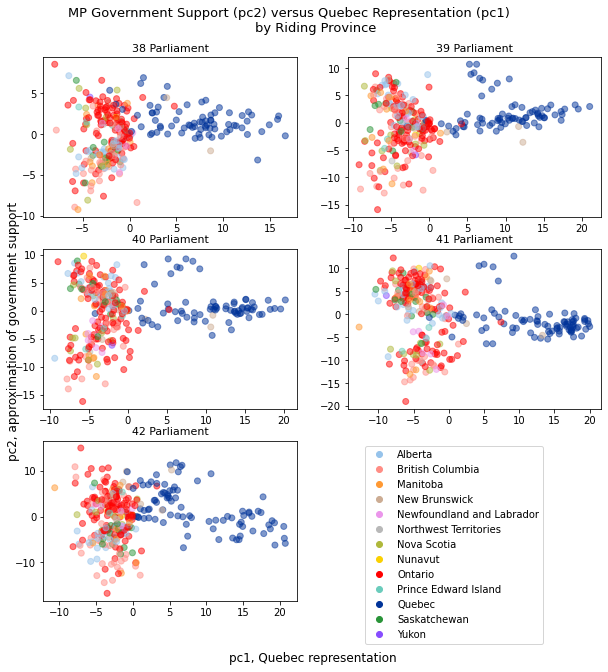

In [9]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axes = [[0,0], [0,1], [1,0], [1,1], [2,0]]

for i, parliament in enumerate(byParliament):
    colorMap = parliament['province'].map(provinceColorDict) 
    axs[axes[i][0],axes[i][1]].scatter(parliament.quebecker, parliament.govtSupport, color=colorMap, alpha=0.5)
    axs[axes[i][0],axes[i][1]].set_title(str(38+i)+' Parliament', size=11)

fig.delaxes(axs[2,1])

fig.suptitle('MP Government Support (pc2) versus Quebec Representation (pc1)\
            \n by Riding Province', fontsize=13, y=0.95)
fig.text(0.5, 0.04, 'pc1, Quebec representation', ha='center', fontsize = 12)
fig.text(0.075, 0.5, 'pc2, approximation of government support', va='center', rotation ='vertical', fontsize=12)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in provinceColorDict.values()]
provincesList = [province.partition('/')[0] for province in provinceColorDict.keys()]
plt.legend(markers, provincesList, numpoints=1, bbox_to_anchor=(1.25, 1))

## Figure 2.3
MP embeddings projected onto two dimensions using PCA over the 38th through 42nd Parliaments labelled by partisan identification.

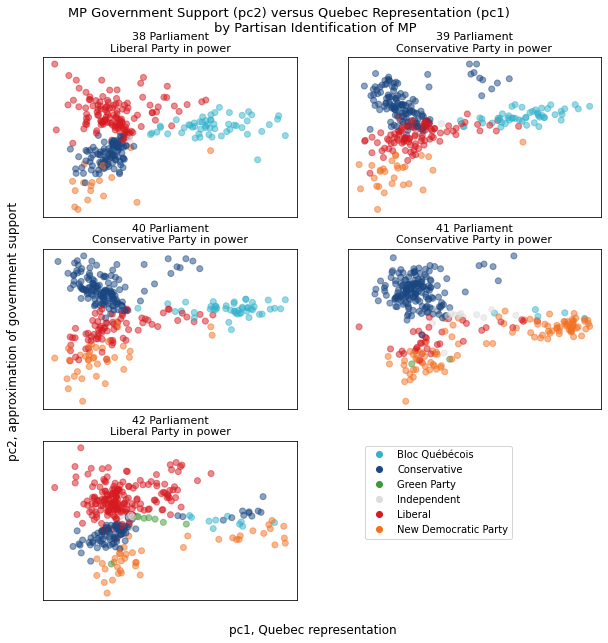

In [10]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axes = [[0,0], [0,1], [1,0], [1,1], [2,0]]
majorityParty = ['Liberal', 'Conservative', 'Conservative', 'Conservative', 'Liberal']

for i, govtSupport in enumerate(byParliament):
    colorMap = govtSupport['speakerparty'].map(partyColorDict) 
    # plot_with_lin_reg(govtSupport, axes[i], colorMap, str(38+i)+' Parliament', 'quebecker', axesTicks=True)
    axs[axes[i][0],axes[i][1]].scatter(govtSupport.quebecker, govtSupport.govtSupport, color=colorMap, alpha=0.5)
    axs[axes[i][0],axes[i][1]].set_title(str(38+i)+' Parliament'+'\n'+majorityParty[i]+' Party in power', size=11)

    axs[axes[i][0],axes[i][1]].axes.xaxis.set_visible(False)
    axs[axes[i][0],axes[i][1]].axes.yaxis.set_visible(False)

fig.delaxes(axs[2,1])

fig.suptitle('MP Government Support (pc2) versus Quebec Representation (pc1)\
            \n by Partisan Identification of MP', fontsize=13, y=0.95)
fig.text(0.5, 0.08, 'pc1, Quebec representation', ha='center', fontsize = 12)
fig.text(0.075, 0.5, 'pc2, approximation of government support', va='center', rotation ='vertical', fontsize=12)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in list(partyColorDict.values())[0:len(partyColorDict.values())-1]]
plt.legend(markers, list(partyColorDict.keys())[0:len(partyColorDict.keys())-1], numpoints=1, bbox_to_anchor=(1.25, 1))

## Figure 4.1
MP government support derived from second component of two-dimensional MP embeddings versus explicit electorate government support (i.e., the vote share of the governing party) for the 38th through 42nd Parliaments (2004-2019). Linear regression lines, first-order coefficient, and 𝑟2 values shown.

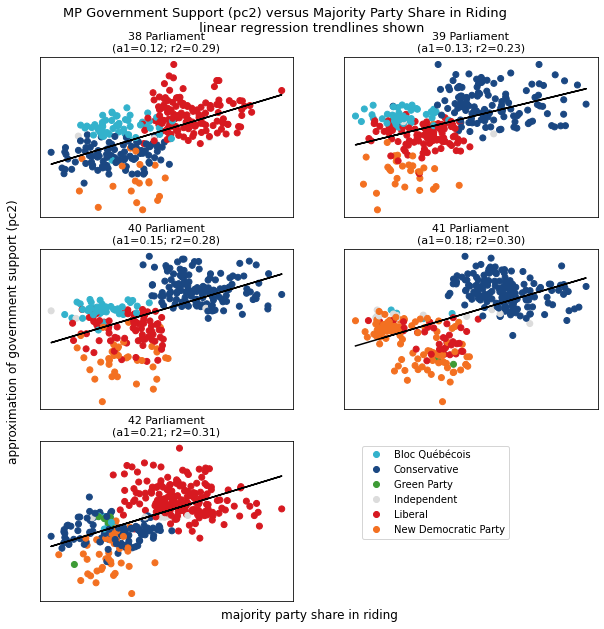

In [11]:
majorityParty = ['Liberal', 'Conservative', 'Conservative', 'Conservative', 'Liberal']

title = 'MP Government Support (pc2) versus Majority Party Share in Riding\
            \n linear regression trendlines shown'
xlabel = 'majority party share in riding'
ylabel = 'approximation of government support (pc2)'
plot_over_parliament(byParliament, majorityParty, 'govtSupport', 'speakerparty', partyColorDict, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 4.2
MP government support derived from second component of two-dimensional MP embeddings versus explicit electorate government support (i.e., the vote share of the governing party) for the 38th through 42nd Parliaments (2004-2019) split by party. Linear regression lines, first-order coefficient, and 𝑟2 values shown.

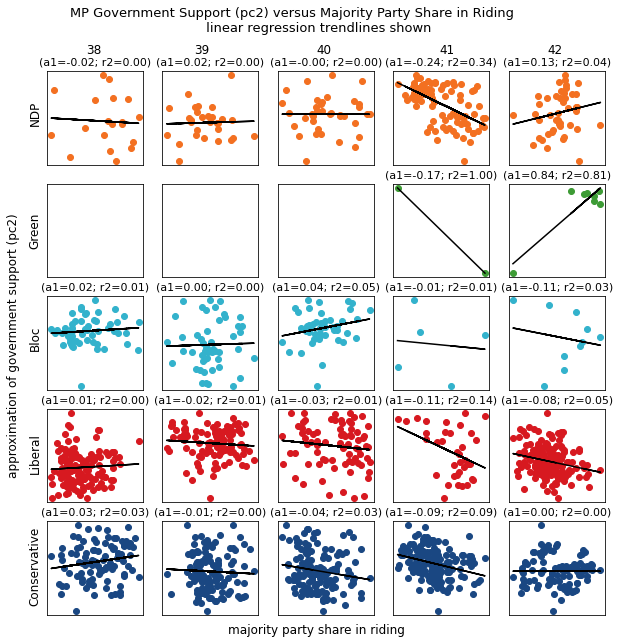

In [12]:
title = 'MP Government Support (pc2) versus Majority Party Share in Riding\
            \n linear regression trendlines shown'
xlabel = 'majority party share in riding'
ylabel = 'approximation of government support (pc2)'
plot_over_parl_party(byParliamentAndParty, majorityParty, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 4.3
MP government support derived from second component of two-dimensional MP embeddings versus riding ideological score derived using RILE weights for the 38th through 42nd Parliaments (2004-2019). Linear regression lines, first-order coefficient, and 𝑟2 values shown.

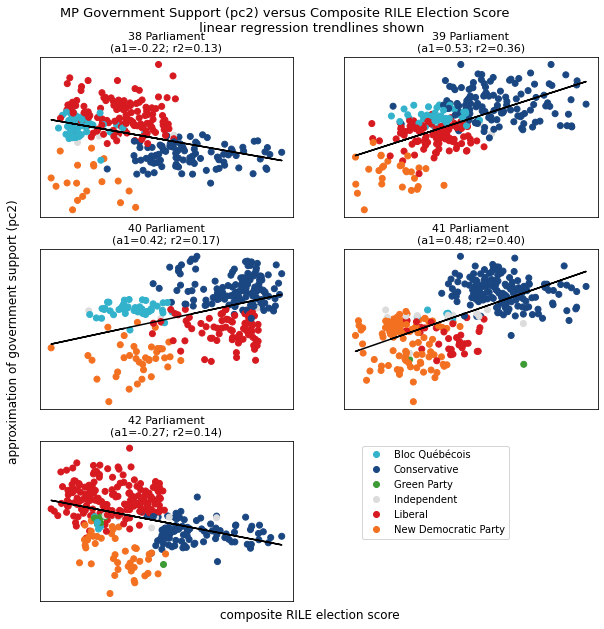

In [13]:
title = 'MP Government Support (pc2) versus Composite RILE Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite RILE election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parliament(byParliament, 'rileScore', 'govtSupport', 'speakerparty', partyColorDict, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 4.4
MP government support derived from second component of two-dimensional MP embeddings versus riding ideological score derived using RILE weights for the 38th through 42nd Parliaments (2004-2019) split by party. Linear regression lines, first-order coefficient, and 𝑟2 values shown.

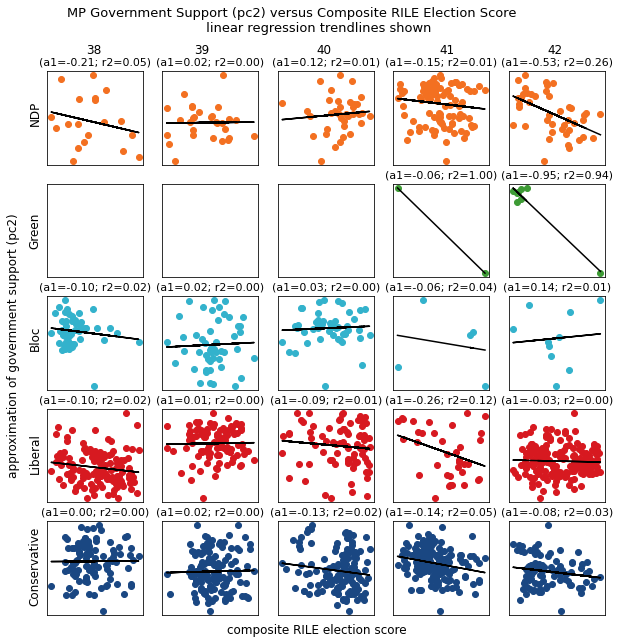

In [14]:
title = 'MP Government Support (pc2) versus Composite RILE Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite RILE election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parl_party(byParliamentAndParty, 'rileScore', title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 9.1

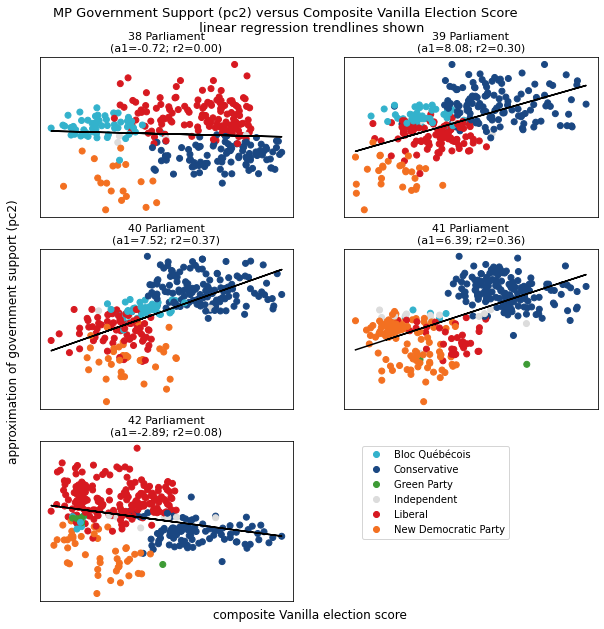

In [15]:
title = 'MP Government Support (pc2) versus Composite Vanilla Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite Vanilla election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parliament(byParliament, 'vanillaScore', 'govtSupport', 'speakerparty', partyColorDict, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 9.2

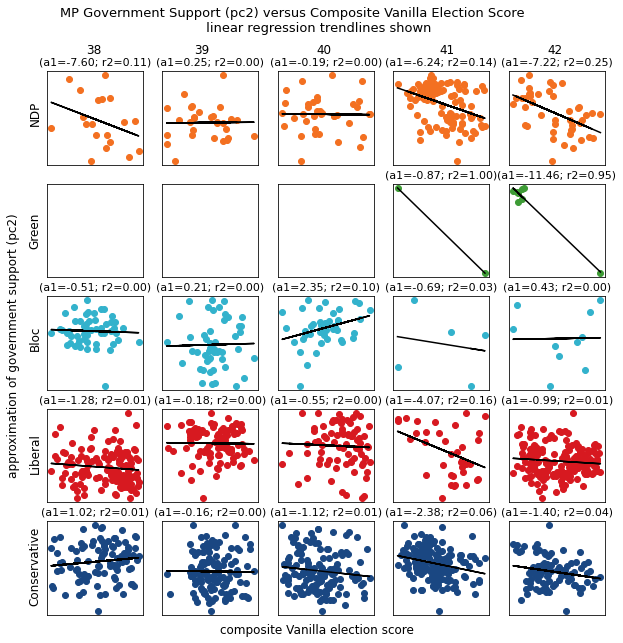

In [16]:
title = 'MP Government Support (pc2) versus Composite Vanilla Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite Vanilla election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parl_party(byParliamentAndParty, 'vanillaScore', title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 9.3

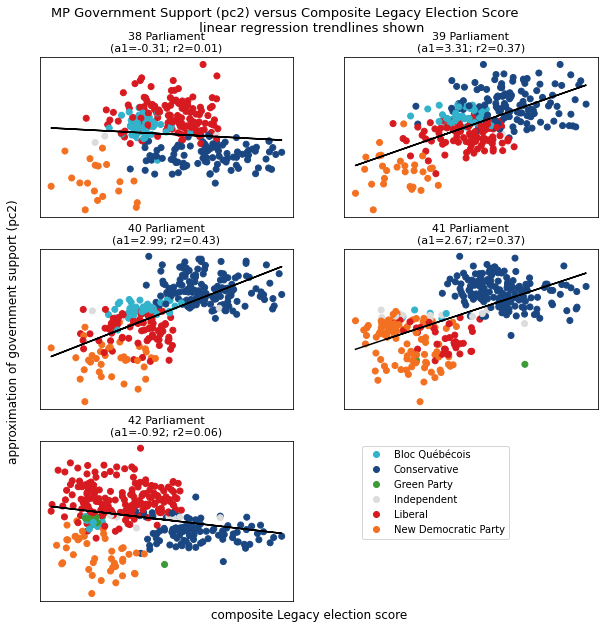

In [17]:
title = 'MP Government Support (pc2) versus Composite Legacy Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite Legacy election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parliament(byParliament, 'legacyScore', 'govtSupport', 'speakerparty', partyColorDict, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 9.4

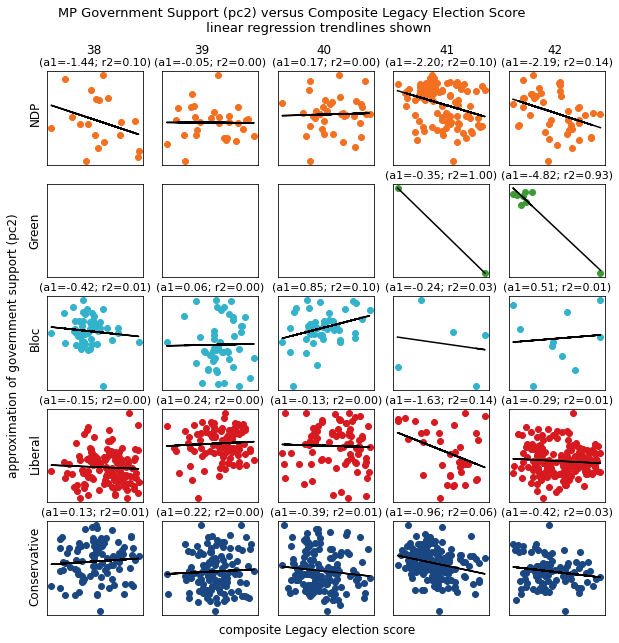

In [18]:
title = 'MP Government Support (pc2) versus Composite Legacy Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite Legacy election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parl_party(byParliamentAndParty, 'legacyScore', title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 4.5
MP support for Quebec issues derived from first component of two-dimensional MP embeddings versus riding support for Quebec nationalism (i.e., vote share of Bloc Québécois) for the 38th through 42nd Parliaments (2004-2019). Linear regression lines, first-order coefficient, and 𝑟2 values shown.

In [19]:
byParliamentQC = [pd.DataFrame(quebeckers[quebeckers['parliamentNo'] == n]) for n in range (38,43,1)]
byParliamentAndPartyQC = [[parl[parl['speakerparty'] == party] for party in partynames] for parl in byParliamentQC]

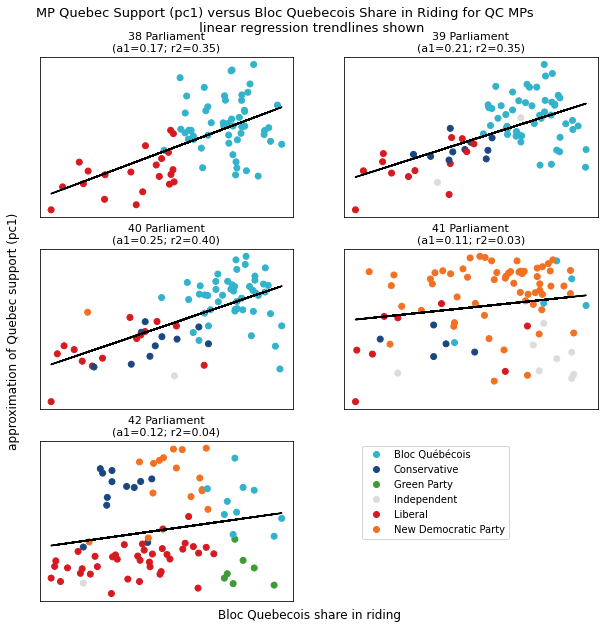

In [20]:
title = 'MP Quebec Support (pc1) versus Bloc Quebecois Share in Riding for QC MPs\
            \n linear regression trendlines shown'
xlabel = 'Bloc Quebecois share in riding'
ylabel = 'approximation of Quebec support (pc1)'
plot_over_parliament(byParliamentQC, 'Bloc Quebecois_share', 'quebecker', 'speakerparty', partyColorDict, title=title, xlabel=xlabel, ylabel=ylabel)

## Figure 4.6
MP support for Quebec issues derived from first component of two-dimensional MP embeddings versus riding support for Quebec nationalism (i.e., vote share of Bloc Québécois) for the 38th through 42nd Parliaments (2004-2019) split by party. Linear regression lines, first-order coefficient, and 𝑟2 values shown.

c:\Users\calla\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


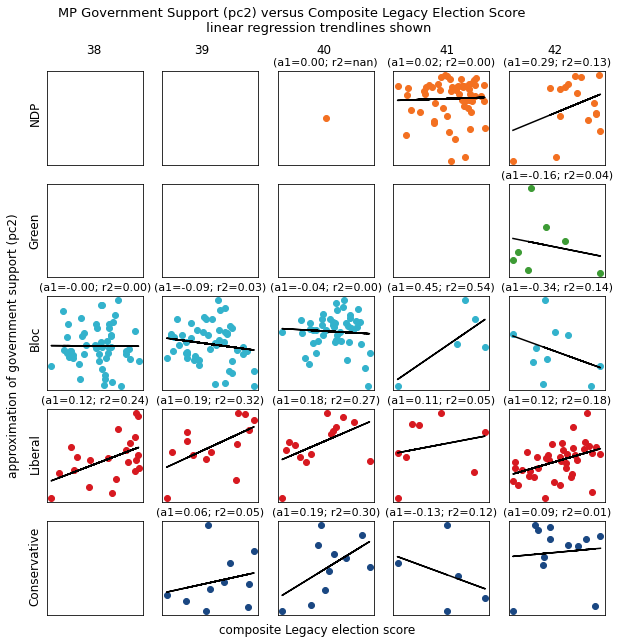

In [21]:
title = 'MP Government Support (pc2) versus Composite Legacy Election Score\
            \n linear regression trendlines shown'
xlabel = 'composite Legacy election score'
ylabel = 'approximation of government support (pc2)'
plot_over_parl_party(byParliamentAndPartyQC, 'Bloc Quebecois_share', title=title, xlabel=xlabel, ylabel=ylabel, depVar='quebecker')